Created: 19-05-2022, Last-Updated: 02-06-2022
# Problem Set 2 (Approximate Dynamic Programming)
## Student: Philine Meyjohann
The goal of this problem set is to study various aspects of TD and LSTD methods in a simple Markov decision process. The process we study is the same controlled queueing system as considered in the first problem set. The definition is repeated for convenience below:
+ **The state space** consists of the integers $0, 1, 2, ..., N-1$, with $N=100$, corresponding to the length of the queue.
+ **The action space** consists of two actions: action $a_{low}$ corresponding to a low service rate
of $q(a_{low})= q_{low} = 0.51$ and action $a_{high}$ corresponding to a high service rate of $q(a_{high}) = q_{high} = 0.6$.
+ **The reward function** assigns a reward of $r(x,a) = -(x/N)^2-c(a)$, with $c(a)$ being the cost of action $a$. This cost is defined for the two actions as $c(a_{low}) = 0$ and $c(a_{high}) = 0.01$.
+ **The transition function** describes the dynamics of the queue as follows. The arrival rate $p = 0.5$ models the rate at which new requests arrive into the queue and the controlled service rate models the rate at which requests leave the queue. In each round, the queue length increases by 1 with probability p and decreases by 1 with probability $q(a)$ corresponding to the action $a$ taken. Precisely, letting $x_t$ be the current queue length, $a_t$ be the action taken by the agent, we define $I_t \in \{0,1\}$ as the increment such that $P[I_t = 1] = p$ and $S_t \in \{0,1\}$ as the decrement such that $P[S_t = 1] = q(a_t)$, the queue length is updated in each round as $$x_{t+1} = trunc(x_t + I_t - S_t),$$ where the “trunc” operator truncates the value to the interval $[0,N-1]: trunc(x) = \min \{N-1, \max\{x,0\}\}$.
+ **The discount factor** will be set as $\gamma = 0.9$.

The task will be to evaluate some simple policies and find a near-optimal policy via temporal-difference learning methods and linear function approximation. We will study three feature maps:
+ **A fine feature map**: a $N+1$-dimensional feature vector, with its i-th component defined as $$\phi^{fine}_i(x) =\mathbf{1}\{x=i\}$$ for each $i = 0, 1, 2, ..., N$. This feature map can represent all functions on the state space.
+ **A coarse feature map**: an $N / 5$-dimensional feature vector with its $i$-th component defined as $$\phi_{i}^{\text {coarse }}(x)=\mathbf{1}\{x \in[5(i-1), 5 i-1]\}.$$ This feature map can represent piecewise constant functions on the state space.|
+ **A piecewise linear feature map**: an $2 \times N / 5$-dimensional feature vector with its first $N / 5$ entries being equal to the previous feature map (i.e., $\phi_{i}^{\text {pwl }}=\phi_{i}^{\text {coarse }}$ for $i=1,2, \ldots, N / 5$ ) and the second $N / 5$ entries defined as $$ \phi_{N / 5+i}^{\mathrm{pwl}}(x)=\mathbf{1}\{x \in[5(i-1), 5 i-1]\} \cdot(x-5(i-1)) / 5,$$ for $i=1,2, \ldots, N / 5$. The normalization constant $1 / 5$ is present to make sure that all features are bounded in $[0,1]$. This feature map can represent piecewise linear functions on the state space.

## Preliminaries

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.random.seed(123)

#np.set_printoptions(threshold=np.inf)

In [2]:
# define basic properties
N = 100
X = N # state space
A = 2 # action space
p = 0.5 # arrival rate
gamma = 0.9 # discount factor

# action space
q_low = 0.51
q_high = 0.6
q = [q_low, q_high]

# costs
c_low = 0
c_high = 0.01
c = [c_low, c_high]

### Define environment and possible functions

In [3]:
# define possible states for plots
states = np.linspace(0,N-1,N).astype('int')
states

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
# define the policies
# policy maps (x,a) pair to probability of taking action a in state x

# lazy policy
pi_lazy = np.zeros((X,A))
for x in range(0,X):
    pi_lazy[x,0] = 1

# aggressive policy
pi_aggr = np.zeros((X,A))
for x in range(0,X):
    if x < X/2:
        pi_aggr[x,0] = 1
    else:
        pi_aggr[x,1] = 1

In [5]:
# define reward
reward = np.zeros((X, A))
for a in range(A):
    for x in range(X):
        reward[x,a] = -(x/N)**2 - c[a]

In [6]:
# constructs a transition model P for queue environment with size (N,N)
# P[x,y,a] gives the probability of moving from state x to state y when taking action a
def move(x,delta_x,N): # 
    new_x = x + delta_x
    return np.maximum(np.minimum(new_x,N-1),0)


def queue_env(N): # constructs X by X transition matrix for policy pi
    P = np.zeros((N, N, A)) 
    for x in range(0,N):
        for y in range(0,N):
            for a in range(0,A):
                if y == move(x,0,N):
                    # Edge case 1: no-one in the queue
                    if x == 0:
                        P[x,y,a] = 1 - ((1-q[a])*p)
                    # Edge case 2: full queue
                    elif x == N-1:
                        P[x,y,a] = 1 - (q[a]*(1-p))
                    # No edge cases
                    else:
                        P[x,y,a] = (1-q[a])*(1-p) + q[a]*p
                elif y == move(x,1,N):
                    P[x,y,a] = (1-q[a])*p
                elif y == move(x,-1,N):
                    P[x,y,a] = q[a]*(1-p)
    return P

In [7]:
P = queue_env(N)
P[:,:,1]

array([[0.8, 0.2, 0. , ..., 0. , 0. , 0. ],
       [0.3, 0.5, 0.2, ..., 0. , 0. , 0. ],
       [0. , 0.3, 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0.2, 0. ],
       [0. , 0. , 0. , ..., 0.3, 0.5, 0.2],
       [0. , 0. , 0. , ..., 0. , 0.3, 0.7]])

In [8]:
# transition matrix for policy pi
def transition(P,pi):
    X = np.size(P,0)
    P_pi = np.zeros((X,X))
    for x in range(X):
        for y in range(X):
            P_pi[x,y]=P[x,y,0]*pi[x,0] + P[x,y,1]*pi[x,1]
    return P_pi

### Define feature maps

In [9]:
# fine feature map
phi_fine = np.zeros((N,N))
for x in range(X):
    for i in range(0,len(phi_fine)):
        if x == i:
            phi_fine[x,i] = 1


# coarse feature map
phi_coarse = np.zeros((N,int(N/5)))
for x in range(X):
    for i in range(0,len(phi_coarse)):
        if x in range((5*(i-1)), (5*i-1)+1):
            phi_coarse[x,i-1] = 1


# piecewise-linear feature map
pwl=np.zeros((X,int(N/5)))
for x in range(X):
    for i in range(1,int(N/5)+1):
        if (x>=5*(i-1)) & (x<=5*i-1):
            pwl[x,i-1]=1*(x-5*(i-1))/5

phi_pwl = np.concatenate([phi_coarse,pwl],axis=1)

## Problem 1: Approximate policy evaluation
The first problem is to study the performance of the same simple policies as in the first problem set, but this time using TD $(0)$ and LSTD with $10^{4}, 10^{5}, 10^{6}$, and $10^{7}$ sample transitions, under the three feature maps. Sample the transitions from one single episode starting from initial state $x_{0}=N$ (a full queue). Plot the resulting value functions and compare them to the results you have obtained in the first problem set. For completeness, the two policies to study are:
+ **Lazy policy**: the policy that always uses the low service rate: $\pi(x)=a_{\text {low }}$.
+ **Aggressive policy**: the policy that uses the low service rate for short queues $\left(\pi(x)=a_{\text {low }}\right.$ for $x<50$ ) and the high service rate for long queues $\left(\pi(x)=a_{\text {high }}\right.$ for $\left.x \geq 50\right)$.

### Hints:
For $\mathrm{TD}(0)$, set a sequence of decreasing stepsize parameters with $\alpha_{t}=\frac{a}{t+b}$ for some tuning parameters $a, b$. (Relatively large values of both $a$ and $b$ such as $a=b=10^{5}$ are recommended so that the stepsize decay is not too fast.) For LSTD, you can use a MoorePenrose pseudoinverse (e.g., numpy.linalg.pinv) or a regularized matrix inverse $(M+$ $\sigma I)^{-1}$ instead of $M^{-1}$ for a small $\sigma$ (e.g., $10^{-10}$ ) if $A_{T}$ is singular.

### TD(0)

In [10]:
def TD0(P,reward,gamma,pi,phi,max_trans,x_0):
    # TD(0) algorithm to evaluate a given policy
    a = 10**5
    b = 10**5

    x = x_0
    theta = np.zeros(phi.shape[1])
    r = reward[:,0]*pi[:,0] + reward[:,1]*pi[:,1]
    P_pi = transition(P,pi)

    for t in range(max_trans):
        alpha = a/(t+b)
        x_new = np.random.choice(list(range(X)), p=P_pi[x,:])

        delta = r[x] + gamma*np.dot(theta.T, phi[x_new,:]) - np.dot(theta.T, phi[x,:])
        theta = theta + alpha*delta*phi[x,:]

        x = x_new

    value = phi.dot(theta)
    return value


In [11]:
%%time

results_TD0 = []
policies = [pi_lazy, pi_aggr]
feature_maps = [phi_fine, phi_coarse, phi_pwl]
max_trans = [10**4, 10**5, 10**6, 10**7]

for pi in policies:
    for phi in feature_maps:
        for n in max_trans:
            td0 = TD0(P,reward,gamma,pi,phi,n,X-1)
            results_TD0.append(td0)

CPU times: user 15min 57s, sys: 11.6 s, total: 16min 9s
Wall time: 24min 38s


In [12]:
labels_TD0 = []
policies = ['lazy', 'aggr']
feature_maps = ['fine', 'coarse', 'pwl']
max_trans = ['4', '5', '6', '7']

for pi in policies:
    for phi in feature_maps:
        for n in max_trans:
            label_TD0 = 'TD0_' + pi + '_' + phi + '_' + n
            labels_TD0.append(label_TD0)

In [13]:
results_TD0 = pd.DataFrame(np.transpose(results_TD0), columns=labels_TD0)
results_TD0

,TD0_lazy_fine_4,TD0_lazy_fine_5,TD0_lazy_fine_6,TD0_lazy_fine_7,TD0_lazy_coarse_4,TD0_lazy_coarse_5,TD0_lazy_coarse_6,TD0_lazy_coarse_7,TD0_lazy_pwl_4,TD0_lazy_pwl_5,...,TD0_aggr_fine_6,TD0_aggr_fine_7,TD0_aggr_coarse_4,TD0_aggr_coarse_5,TD0_aggr_coarse_6,TD0_aggr_coarse_7,TD0_aggr_pwl_4,TD0_aggr_pwl_5,TD0_aggr_pwl_6,TD0_aggr_pwl_7
0,-0.000649,-0.001563,-0.002513,-0.003095,-0.012621,-0.032086,-0.031761,-0.022102,-0.065011,-0.011089,...,-0.002671,-0.002977,-0.018756,-0.019506,-0.019725,-0.018847,-0.004591,-0.011167,-0.005006,-0.001629
1,-0.002508,-0.003258,-0.004028,-0.004548,-0.012621,-0.032086,-0.031761,-0.022102,-0.077907,-0.013581,...,-0.004118,-0.004477,-0.018756,-0.019506,-0.019725,-0.018847,-0.006762,-0.013901,-0.008830,-0.005783
2,-0.006938,-0.006615,-0.007028,-0.007701,-0.012621,-0.032086,-0.031761,-0.022102,-0.090803,-0.016073,...,-0.007584,-0.007584,-0.018756,-0.019506,-0.019725,-0.018847,-0.008934,-0.016636,-0.012655,-0.009937
3,-0.012481,-0.011345,-0.013188,-0.012855,-0.012621,-0.032086,-0.031761,-0.022102,-0.103698,-0.018565,...,-0.014670,-0.012348,-0.018756,-0.019506,-0.019725,-0.018847,-0.011106,-0.019370,-0.016479,-0.014091
4,-0.013168,-0.017913,-0.020206,-0.019404,-0.012621,-0.032086,-0.031761,-0.022102,-0.116594,-0.021056,...,-0.019752,-0.019407,-0.018756,-0.019506,-0.019725,-0.018847,-0.013278,-0.022104,-0.020304,-0.018244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-8.710259,-4.665436,-9.005017,-9.009278,-8.913555,-9.147195,-8.970062,-9.034778,-2.644355,-9.061961,...,-3.709573,-0.913082,-2.463086,-3.706544,-0.914630,-0.916012,-0.912941,0.038021,-0.059982,-0.913594
96,-8.939930,-5.592454,-9.164694,-9.164667,-8.913555,-9.147195,-8.970062,-9.034778,-3.392135,-9.120203,...,-2.507890,-2.508132,-2.463086,-3.706544,-0.914630,-0.916012,-1.563878,-0.562551,-0.794583,-1.500508
97,-9.216646,-6.409965,-9.297523,-9.339950,-8.913555,-9.147195,-8.970062,-9.034778,-4.139915,-9.178446,...,-0.950900,-5.772328,-2.463086,-3.706544,-0.914630,-0.916012,-2.214814,-1.163122,-1.529183,-2.087422
98,-8.259288,-9.146818,-9.460815,-9.495654,-8.913555,-9.147195,-8.970062,-9.034778,-4.887695,-9.236689,...,-0.970466,-0.970371,-2.463086,-3.706544,-0.914630,-0.916012,-2.865750,-1.763694,-2.263784,-2.674336


### LSTD
I replicate the algorithm as specified in Sutton and Barto (2018) using a regularized matrix inverse.
<div>
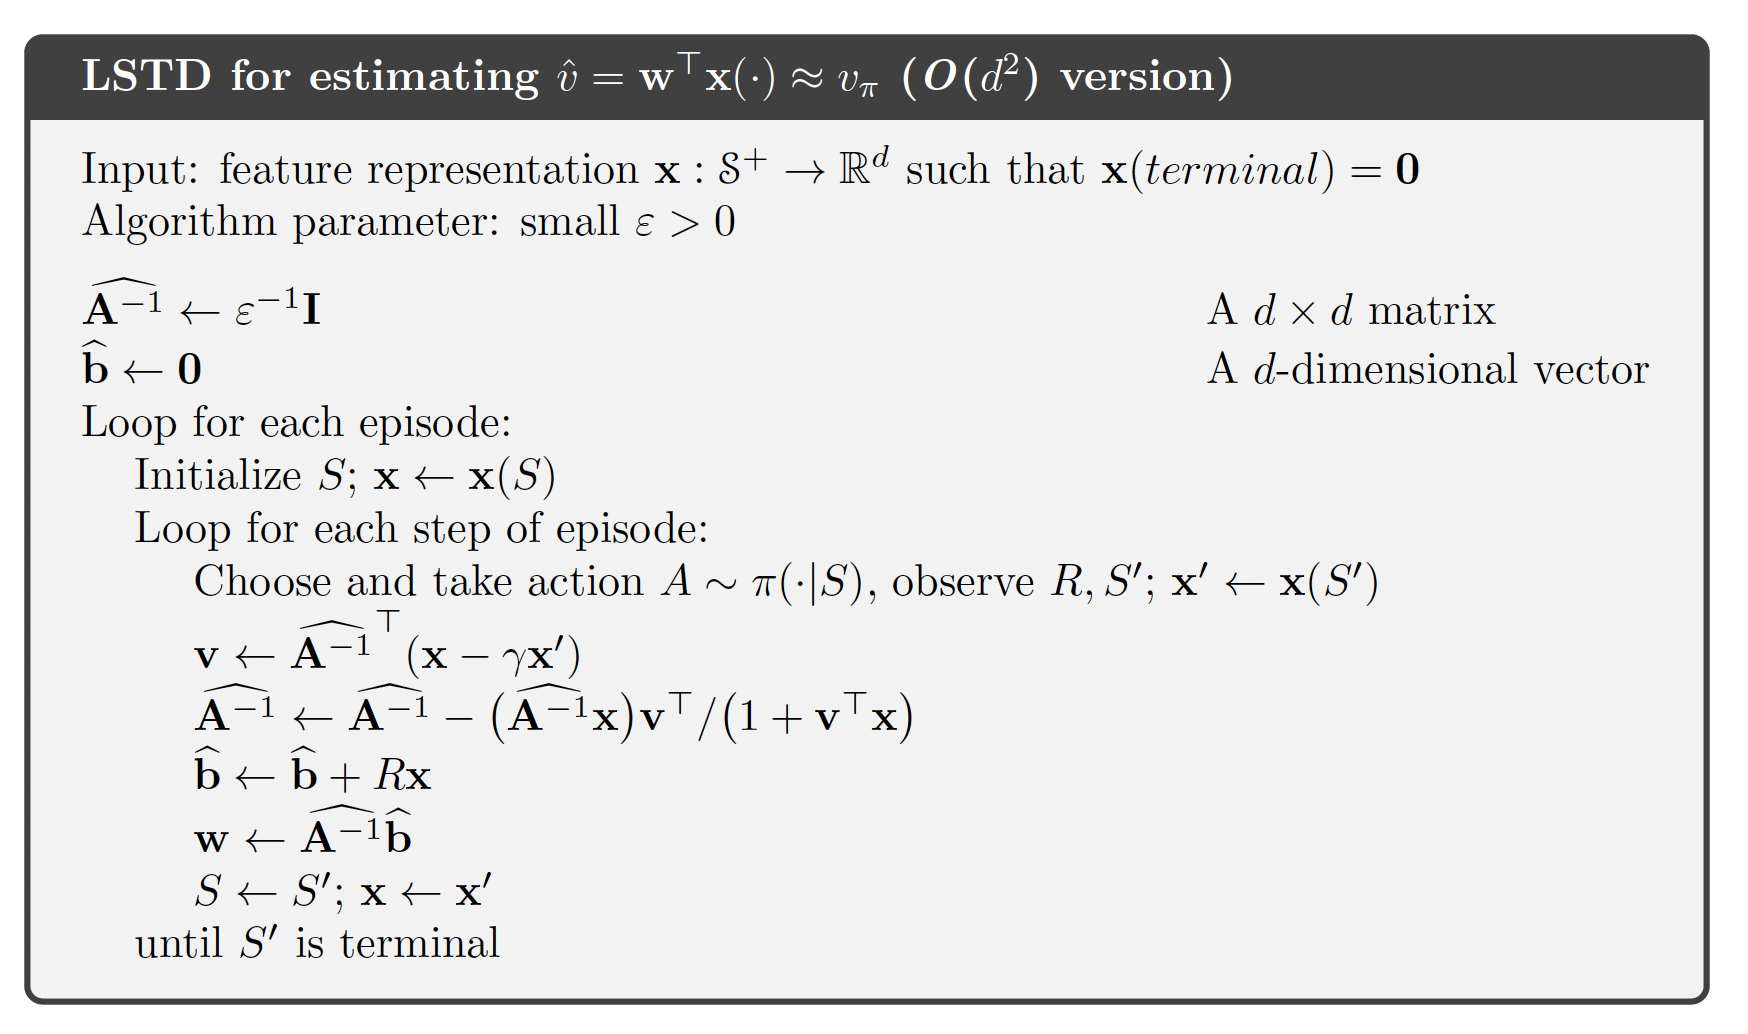
</div>

In [14]:
def LSTD(P,reward,gamma,pi,phi,max_trans,x_0,sigma=10**-10):
    A = np.zeros((phi.shape[1], phi.shape[1]))
    A_1 = np.linalg.inv(A + (sigma*np.identity(phi.shape[1])))
    b = np.zeros(phi.shape[1])
    
    x = x_0
    r = reward[:,0]*pi[:,0] + reward[:,1]*pi[:,1]
    P_pi = transition(P,pi)

    for t in range(max_trans):
        x_new = np.random.choice(list(range(X)), p=P_pi[x,:]) # initialize new state x'
        v = np.dot(A_1.T,phi[x,:] - gamma*phi[x_new,:])
        A_1 = A_1 - np.outer(np.dot(A_1, phi[x,:]), v.T)/(1 + np.dot(v, phi[x,:]))
        b += r[x]*phi[x,:]
        x = x_new # update states
    
    theta = A_1.dot(b)
    value = phi.dot(theta)
    
    return value

In [15]:
%%time

results_LSTD = []
policies = [pi_lazy, pi_aggr]
feature_maps = [phi_fine, phi_coarse, phi_pwl]
max_trans = [10**4, 10**5, 10**6, 10**7]

for pi in policies:
    for phi in feature_maps:
        for n in max_trans:
            lstd = LSTD(P,reward,gamma,pi,phi,n,X-1)
            results_LSTD.append(lstd)

CPU times: user 3h 48min 38s, sys: 3min 40s, total: 3h 52min 18s
Wall time: 1h 57min 17s


In [16]:
labels_LSTD = []
policies = ['lazy', 'aggr']
feature_maps = ['fine', 'coarse', 'pwl']
max_trans = ['4', '5', '6', '7']

for pi in policies:
    for phi in feature_maps:
        for n in max_trans:
            label_LSTD = 'LSTD_' + pi + '_' + phi + '_' + n
            labels_LSTD.append(label_LSTD)

In [17]:
results_LSTD = pd.DataFrame(np.transpose(results_LSTD), columns=labels_LSTD)
results_LSTD

,LSTD_lazy_fine_4,LSTD_lazy_fine_5,LSTD_lazy_fine_6,LSTD_lazy_fine_7,LSTD_lazy_coarse_4,LSTD_lazy_coarse_5,LSTD_lazy_coarse_6,LSTD_lazy_coarse_7,LSTD_lazy_pwl_4,LSTD_lazy_pwl_5,...,LSTD_aggr_fine_6,LSTD_aggr_fine_7,LSTD_aggr_coarse_4,LSTD_aggr_coarse_5,LSTD_aggr_coarse_6,LSTD_aggr_coarse_7,LSTD_aggr_pwl_4,LSTD_aggr_pwl_5,LSTD_aggr_pwl_6,LSTD_aggr_pwl_7
0,-0.005808,-0.003254,-0.003150,-0.003175,-0.021264,-0.022281,-0.023138,-0.022971,-0.001511,-0.001516,...,-0.003173,-0.003208,-0.038258,-0.022568,-0.023459,-0.022858,-0.001348,-0.001466,-0.001475,-0.001508
1,-0.008711,-0.004754,-0.004587,-0.004616,-0.021264,-0.022281,-0.023138,-0.022971,-0.006145,-0.005565,...,-0.004605,-0.004659,-0.038258,-0.022568,-0.023459,-0.022858,-0.005315,-0.005420,-0.005550,-0.005570
2,-0.013329,-0.008020,-0.007724,-0.007758,-0.021264,-0.022281,-0.023138,-0.022971,-0.010779,-0.009615,...,-0.007726,-0.007798,-0.038258,-0.022568,-0.023459,-0.022858,-0.009283,-0.009375,-0.009625,-0.009632
3,-0.018229,-0.012998,-0.012709,-0.012748,-0.021264,-0.022281,-0.023138,-0.022971,-0.015414,-0.013664,...,-0.012694,-0.012781,-0.038258,-0.022568,-0.023459,-0.022858,-0.013250,-0.013330,-0.013700,-0.013694
4,-0.029890,-0.020109,-0.019642,-0.019659,-0.021264,-0.022281,-0.023138,-0.022971,-0.020048,-0.017714,...,-0.019616,-0.019684,-0.038258,-0.022568,-0.023459,-0.022858,-0.017217,-0.017284,-0.017774,-0.017756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-8.948034,-9.021575,-8.983697,-8.996437,-9.130491,-8.921332,-9.121751,-9.040952,-9.044584,-8.974169,...,-8.649693,-8.821519,-9.087642,-9.145862,-9.263440,-9.041848,-8.369696,-9.060823,-8.773541,-8.571105
96,-9.111897,-9.187911,-9.196040,-9.171537,-9.130491,-8.921332,-9.121751,-9.040952,-9.184782,-9.123890,...,-8.891481,-8.870967,-9.087642,-9.145862,-9.263440,-9.041848,-8.626815,-9.216670,-8.882793,-8.798533
97,-9.460184,-9.342873,-9.386194,-9.336118,-9.130491,-8.921332,-9.121751,-9.040952,-9.324980,-9.273610,...,-9.186387,-8.986974,-9.087642,-9.145862,-9.263440,-9.041848,-8.883933,-9.372517,-8.992045,-9.025960
98,-9.564055,-9.467444,-9.515815,-9.481703,-9.130491,-8.921332,-9.121751,-9.040952,-9.465179,-9.423331,...,-9.373755,-9.243054,-9.087642,-9.145862,-9.263440,-9.041848,-9.141052,-9.528364,-9.101298,-9.253387


### Save results and compare to value functions from previous problem set

In [18]:
# merge the two results dataframes
results_df = results_TD0.join(results_LSTD)
results_df

,TD0_lazy_fine_4,TD0_lazy_fine_5,TD0_lazy_fine_6,TD0_lazy_fine_7,TD0_lazy_coarse_4,TD0_lazy_coarse_5,TD0_lazy_coarse_6,TD0_lazy_coarse_7,TD0_lazy_pwl_4,TD0_lazy_pwl_5,...,LSTD_aggr_fine_6,LSTD_aggr_fine_7,LSTD_aggr_coarse_4,LSTD_aggr_coarse_5,LSTD_aggr_coarse_6,LSTD_aggr_coarse_7,LSTD_aggr_pwl_4,LSTD_aggr_pwl_5,LSTD_aggr_pwl_6,LSTD_aggr_pwl_7
0,-0.000649,-0.001563,-0.002513,-0.003095,-0.012621,-0.032086,-0.031761,-0.022102,-0.065011,-0.011089,...,-0.003173,-0.003208,-0.038258,-0.022568,-0.023459,-0.022858,-0.001348,-0.001466,-0.001475,-0.001508
1,-0.002508,-0.003258,-0.004028,-0.004548,-0.012621,-0.032086,-0.031761,-0.022102,-0.077907,-0.013581,...,-0.004605,-0.004659,-0.038258,-0.022568,-0.023459,-0.022858,-0.005315,-0.005420,-0.005550,-0.005570
2,-0.006938,-0.006615,-0.007028,-0.007701,-0.012621,-0.032086,-0.031761,-0.022102,-0.090803,-0.016073,...,-0.007726,-0.007798,-0.038258,-0.022568,-0.023459,-0.022858,-0.009283,-0.009375,-0.009625,-0.009632
3,-0.012481,-0.011345,-0.013188,-0.012855,-0.012621,-0.032086,-0.031761,-0.022102,-0.103698,-0.018565,...,-0.012694,-0.012781,-0.038258,-0.022568,-0.023459,-0.022858,-0.013250,-0.013330,-0.013700,-0.013694
4,-0.013168,-0.017913,-0.020206,-0.019404,-0.012621,-0.032086,-0.031761,-0.022102,-0.116594,-0.021056,...,-0.019616,-0.019684,-0.038258,-0.022568,-0.023459,-0.022858,-0.017217,-0.017284,-0.017774,-0.017756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-8.710259,-4.665436,-9.005017,-9.009278,-8.913555,-9.147195,-8.970062,-9.034778,-2.644355,-9.061961,...,-8.649693,-8.821519,-9.087642,-9.145862,-9.263440,-9.041848,-8.369696,-9.060823,-8.773541,-8.571105
96,-8.939930,-5.592454,-9.164694,-9.164667,-8.913555,-9.147195,-8.970062,-9.034778,-3.392135,-9.120203,...,-8.891481,-8.870967,-9.087642,-9.145862,-9.263440,-9.041848,-8.626815,-9.216670,-8.882793,-8.798533
97,-9.216646,-6.409965,-9.297523,-9.339950,-8.913555,-9.147195,-8.970062,-9.034778,-4.139915,-9.178446,...,-9.186387,-8.986974,-9.087642,-9.145862,-9.263440,-9.041848,-8.883933,-9.372517,-8.992045,-9.025960
98,-8.259288,-9.146818,-9.460815,-9.495654,-8.913555,-9.147195,-8.970062,-9.034778,-4.887695,-9.236689,...,-9.373755,-9.243054,-9.087642,-9.145862,-9.263440,-9.041848,-9.141052,-9.528364,-9.101298,-9.253387


In [19]:
# calculate value function from previous problem set
def evaluate(P,pi,r,gamma):
    X = np.size(P,0)
    value = np.zeros((X))
    
    r = r[:,0]*pi[:,0] + r[:,1]*pi[:,1]

    P_pi = transition(P,pi)
    I = np.eye(X)
    value = np.linalg.inv(I-gamma*P_pi).dot(r)

    return value

In [20]:
value_lazy = evaluate(P, pi_lazy, reward, gamma)
value_aggr = evaluate(P, pi_aggr, reward, gamma)

In [21]:
results_df['value_lazy'] = value_lazy
results_df['value_aggr'] = value_aggr

### Plot comparison for lazy policy

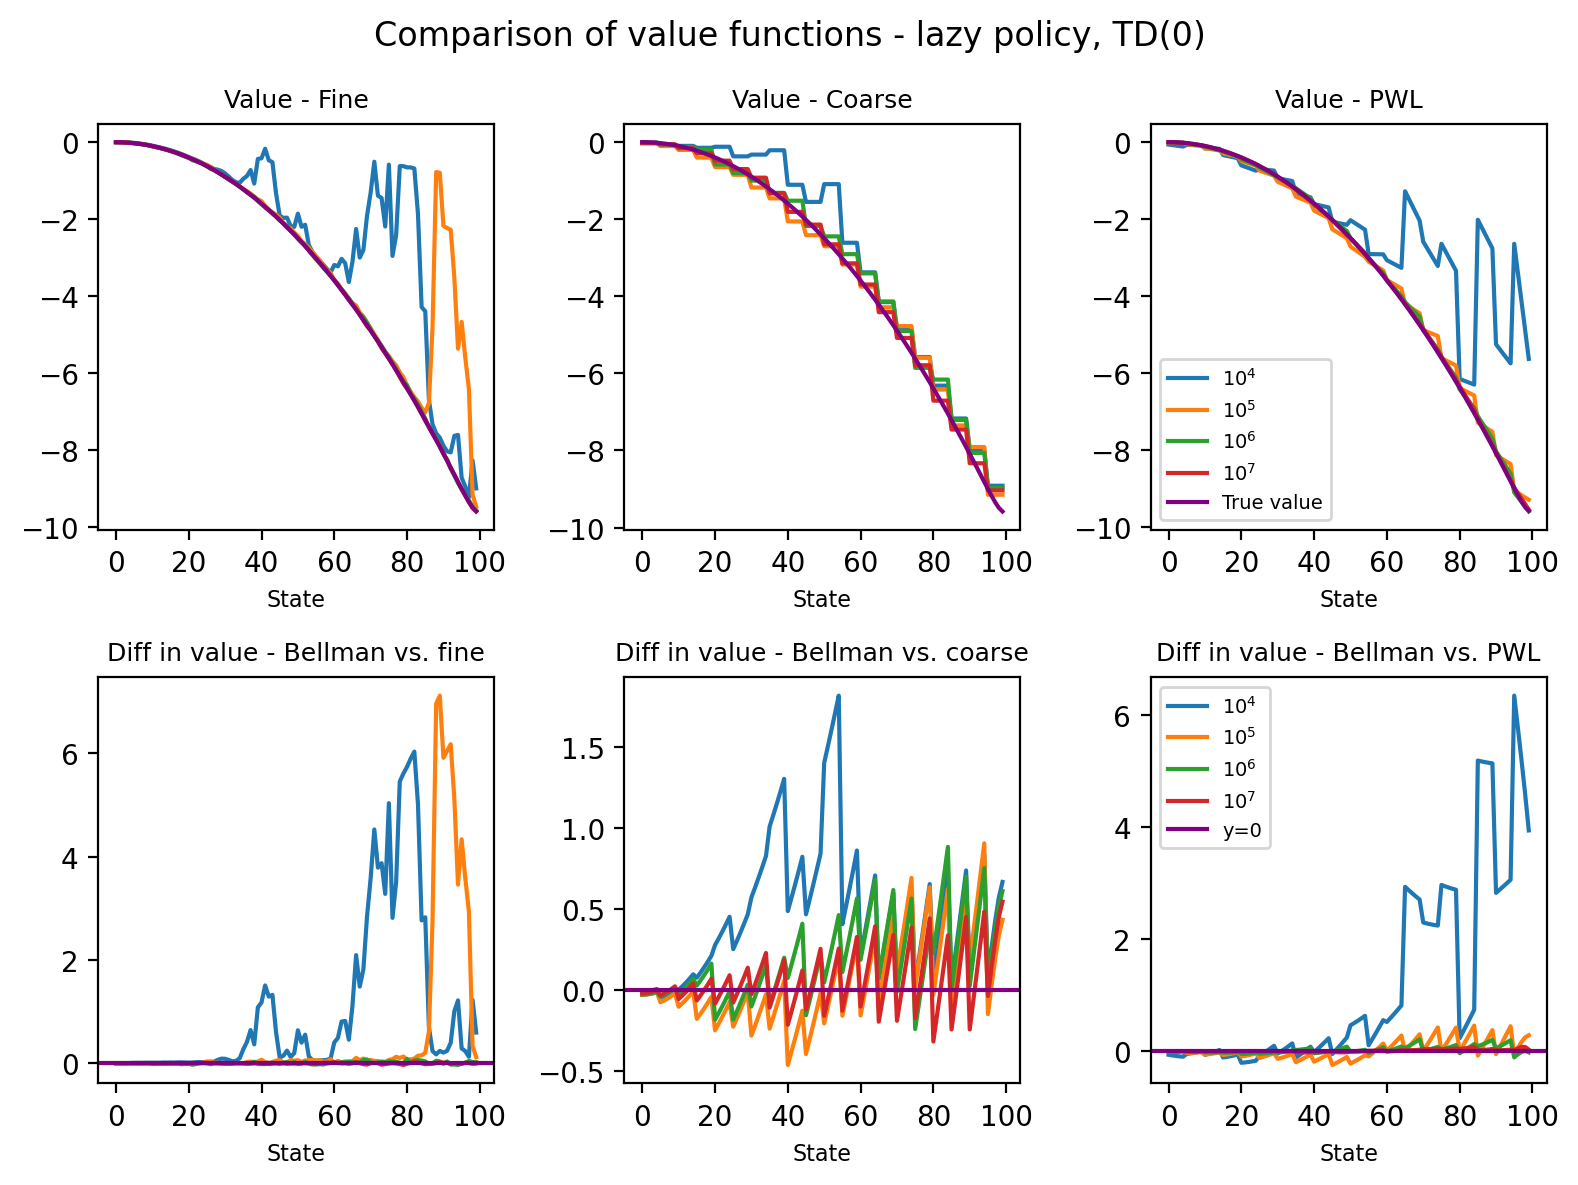

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6), dpi=200)
ax[0,0].plot(np.arange(100),results_df['TD0_lazy_fine_4'], label = '$10^4$')
ax[0,0].plot(np.arange(100),results_df['TD0_lazy_fine_5'], label = '$10^5$')
ax[0,0].plot(np.arange(100),results_df['TD0_lazy_fine_6'], label = '$10^6$')
ax[0,0].plot(np.arange(100),results_df['TD0_lazy_fine_7'], label = '$10^7$')
ax[0,0].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,0].set_title('Value - Fine', fontsize = 9)
ax[0,1].plot(np.arange(100),results_df['TD0_lazy_coarse_4'], label = '$10^4$')
ax[0,1].plot(np.arange(100),results_df['TD0_lazy_coarse_5'], label = '$10^5$')
ax[0,1].plot(np.arange(100),results_df['TD0_lazy_coarse_6'], label = '$10^6$')
ax[0,1].plot(np.arange(100),results_df['TD0_lazy_coarse_7'], label = '$10^7$')
ax[0,1].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,1].set_title('Value - Coarse', fontsize = 9)
ax[0,2].plot(np.arange(100),results_df['TD0_lazy_pwl_4'], label = '$10^4$')
ax[0,2].plot(np.arange(100),results_df['TD0_lazy_pwl_5'], label = '$10^5$')
ax[0,2].plot(np.arange(100),results_df['TD0_lazy_pwl_6'], label = '$10^6$')
ax[0,2].plot(np.arange(100),results_df['TD0_lazy_pwl_7'], label = '$10^7$')
ax[0,2].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,2].set_title('Value - PWL', fontsize = 9)
ax[0,2].legend(loc='lower left', prop={'size': 7})
ax[1,0].plot(np.arange(100),results_df['TD0_lazy_fine_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,0].plot(np.arange(100),results_df['TD0_lazy_fine_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,0].plot(np.arange(100),results_df['TD0_lazy_fine_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,0].plot(np.arange(100),results_df['TD0_lazy_fine_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,0].axhline(y=0, label="y=0", color="purple")
ax[1,0].set_title('Diff in value - Bellman vs. fine', fontsize = 9)
ax[1,1].plot(np.arange(100),results_df['TD0_lazy_coarse_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,1].plot(np.arange(100),results_df['TD0_lazy_coarse_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,1].plot(np.arange(100),results_df['TD0_lazy_coarse_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,1].plot(np.arange(100),results_df['TD0_lazy_coarse_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,1].axhline(y=0, label="y=0", color="purple")
ax[1,1].set_title('Diff in value - Bellman vs. coarse', fontsize = 9)
ax[1,2].plot(np.arange(100),results_df['TD0_lazy_pwl_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,2].plot(np.arange(100),results_df['TD0_lazy_pwl_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,2].plot(np.arange(100),results_df['TD0_lazy_pwl_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,2].plot(np.arange(100),results_df['TD0_lazy_pwl_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,2].axhline(y=0, label="y=0", color="purple")
ax[1,2].set_title('Diff in value - Bellman vs. PWL', fontsize = 9)
ax[1,2].legend(loc='upper left', prop={'size': 7})
for axs in ax.flat:
    axs.set_xlabel('State', fontsize = 8)
    axs.set_xticks(np.arange(0, 101, step=20), fontsize=5)
    #axs.set_yticks(fontsize=5)
fig.suptitle('Comparison of value functions - lazy policy, TD(0)', fontsize=12)

plt.tight_layout()
plt.show()

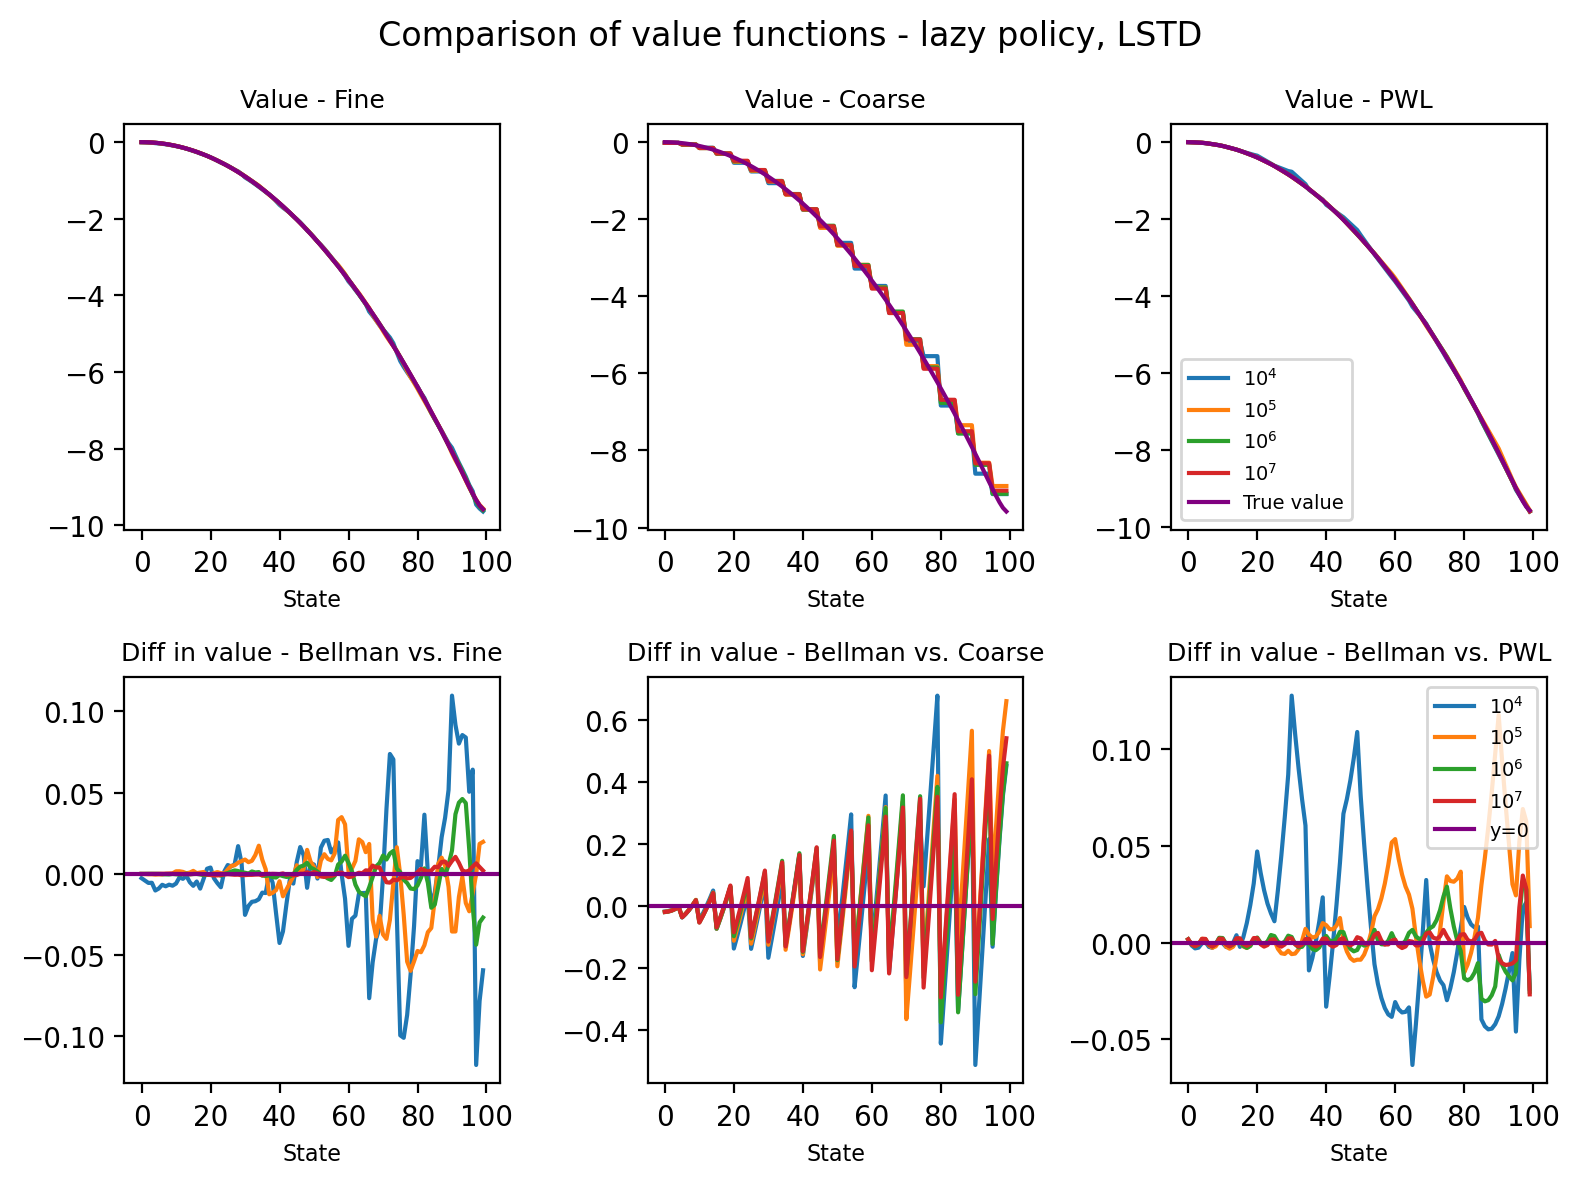

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6), dpi=200)
ax[0,0].plot(np.arange(100),results_df['LSTD_lazy_fine_4'], label = '$10^4$')
ax[0,0].plot(np.arange(100),results_df['LSTD_lazy_fine_5'], label = '$10^5$')
ax[0,0].plot(np.arange(100),results_df['LSTD_lazy_fine_6'], label = '$10^6$')
ax[0,0].plot(np.arange(100),results_df['LSTD_lazy_fine_7'], label = '$10^7$')
ax[0,0].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,0].set_title('Value - Fine', fontsize = 9)
ax[0,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_4'], label = '$10^4$')
ax[0,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_5'], label = '$10^5$')
ax[0,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_6'], label = '$10^6$')
ax[0,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_7'], label = '$10^7$')
ax[0,1].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,1].set_title('Value - Coarse', fontsize = 9)
ax[0,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_4'], label = '$10^4$')
ax[0,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_5'], label = '$10^5$')
ax[0,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_6'], label = '$10^6$')
ax[0,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_7'], label = '$10^7$')
ax[0,2].plot(np.arange(100),results_df['value_lazy'], label = 'True value', color="purple")
ax[0,2].set_title('Value - PWL', fontsize = 9)
ax[0,2].legend(loc='lower left', prop={'size': 7})
ax[1,0].plot(np.arange(100),results_df['LSTD_lazy_fine_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,0].plot(np.arange(100),results_df['LSTD_lazy_fine_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,0].plot(np.arange(100),results_df['LSTD_lazy_fine_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,0].plot(np.arange(100),results_df['LSTD_lazy_fine_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,0].axhline(y=0, label="y=0", color="purple")
ax[1,0].set_title('Diff in value - Bellman vs. Fine', fontsize = 9)
ax[1,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,1].plot(np.arange(100),results_df['LSTD_lazy_coarse_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,1].axhline(y=0, label="y=0", color="purple")
ax[1,1].set_title('Diff in value - Bellman vs. Coarse', fontsize = 9)
ax[1,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_4']-results_df['value_lazy'], label = '$10^4$')
ax[1,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_5']-results_df['value_lazy'], label = '$10^5$')
ax[1,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_6']-results_df['value_lazy'], label = '$10^6$')
ax[1,2].plot(np.arange(100),results_df['LSTD_lazy_pwl_7']-results_df['value_lazy'], label = '$10^7$')
ax[1,2].axhline(y=0, label="y=0", color="purple")
ax[1,2].set_title('Diff in value - Bellman vs. PWL', fontsize = 9)
ax[1,2].legend(loc='upper right', prop={'size': 7})
for axs in ax.flat:
    axs.set_xlabel('State', fontsize = 8)
    axs.set_xticks(np.arange(0, 101, step=20), fontsize=5)
    #axs.set_yticks(fontsize=5)
fig.suptitle('Comparison of value functions - lazy policy, LSTD', fontsize=12)

plt.tight_layout()
plt.show()

### Plot comparison for aggressive policy

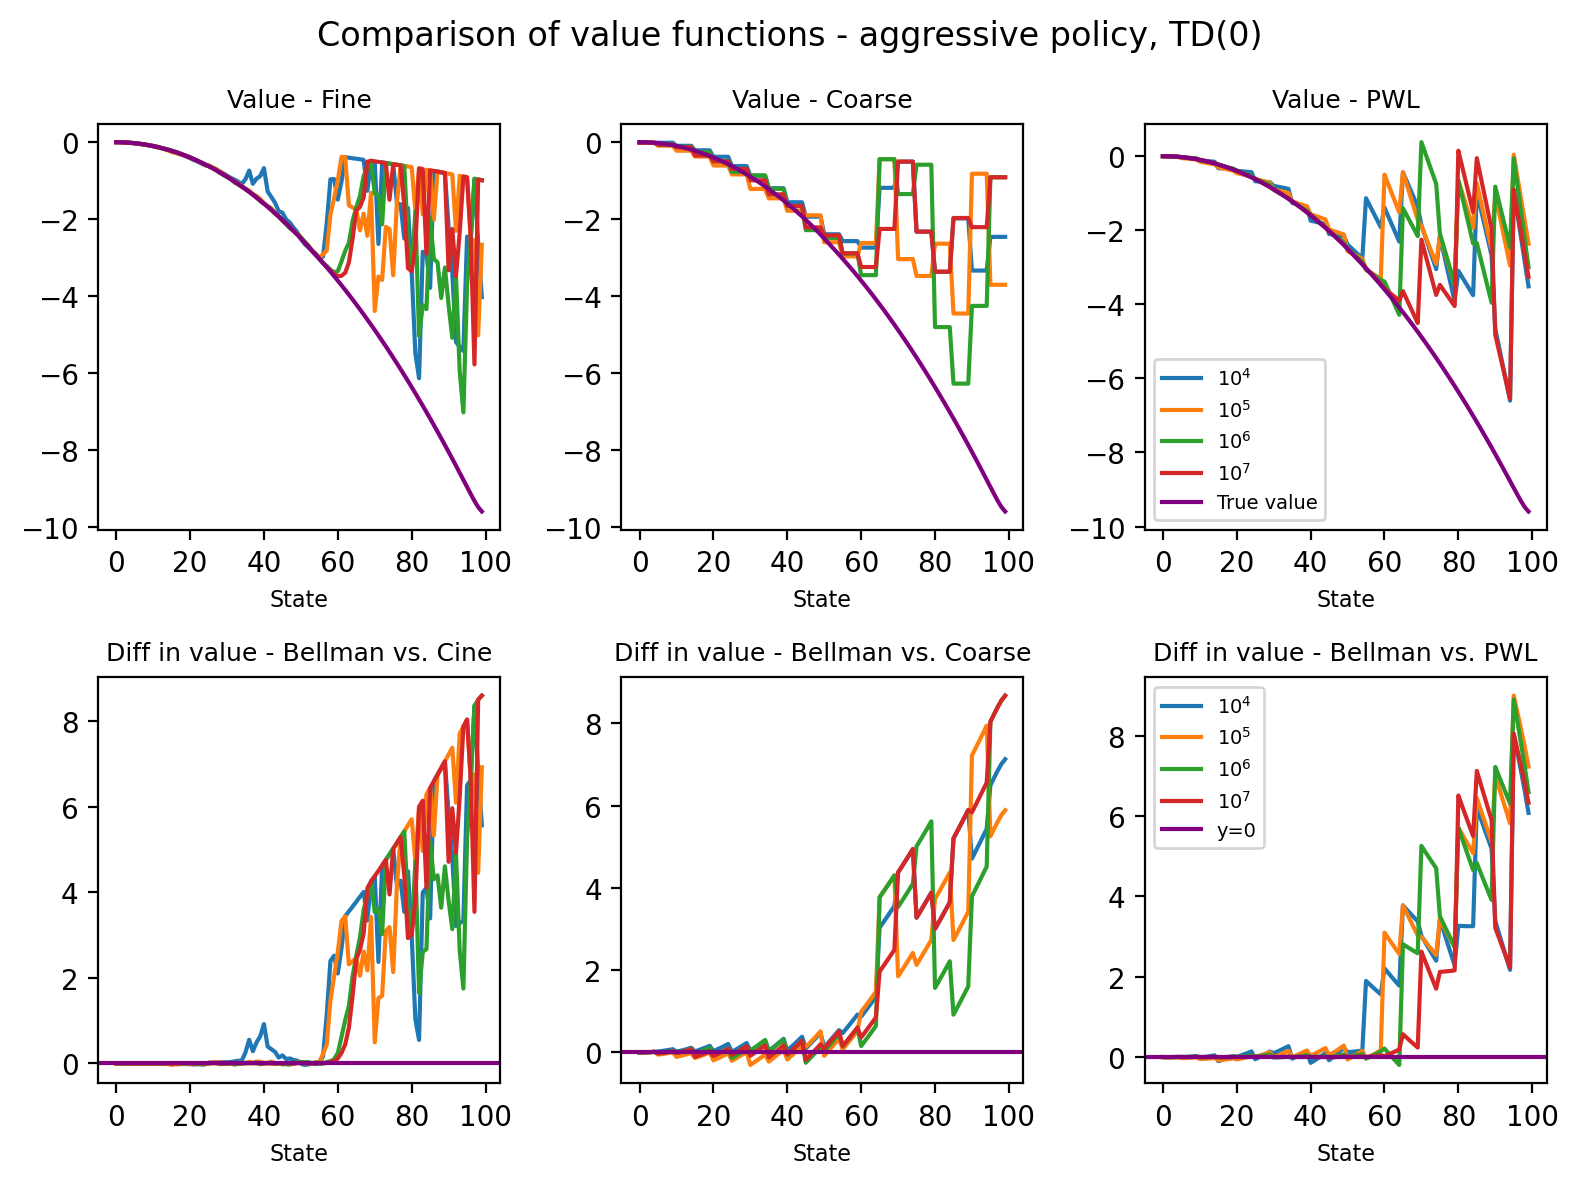

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6), dpi=200)
ax[0,0].plot(np.arange(100),results_df['TD0_aggr_fine_4'], label = '$10^4$')
ax[0,0].plot(np.arange(100),results_df['TD0_aggr_fine_5'], label = '$10^5$')
ax[0,0].plot(np.arange(100),results_df['TD0_aggr_fine_6'], label = '$10^6$')
ax[0,0].plot(np.arange(100),results_df['TD0_aggr_fine_7'], label = '$10^7$')
ax[0,0].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,0].set_title('Value - Fine', fontsize = 9)
ax[0,1].plot(np.arange(100),results_df['TD0_aggr_coarse_4'], label = '$10^4$')
ax[0,1].plot(np.arange(100),results_df['TD0_aggr_coarse_5'], label = '$10^5$')
ax[0,1].plot(np.arange(100),results_df['TD0_aggr_coarse_6'], label = '$10^6$')
ax[0,1].plot(np.arange(100),results_df['TD0_aggr_coarse_7'], label = '$10^7$')
ax[0,1].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,1].set_title('Value - Coarse', fontsize = 9)
ax[0,2].plot(np.arange(100),results_df['TD0_aggr_pwl_4'], label = '$10^4$')
ax[0,2].plot(np.arange(100),results_df['TD0_aggr_pwl_5'], label = '$10^5$')
ax[0,2].plot(np.arange(100),results_df['TD0_aggr_pwl_6'], label = '$10^6$')
ax[0,2].plot(np.arange(100),results_df['TD0_aggr_pwl_7'], label = '$10^7$')
ax[0,2].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,2].set_title('Value - PWL', fontsize = 9)
ax[0,2].legend(loc='lower left', prop={'size': 7})
ax[1,0].plot(np.arange(100),results_df['TD0_aggr_fine_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,0].plot(np.arange(100),results_df['TD0_aggr_fine_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,0].plot(np.arange(100),results_df['TD0_aggr_fine_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,0].plot(np.arange(100),results_df['TD0_aggr_fine_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,0].axhline(y=0, label="y=0", color="purple")
ax[1,0].set_title('Diff in value - Bellman vs. Cine', fontsize = 9)
ax[1,1].plot(np.arange(100),results_df['TD0_aggr_coarse_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,1].plot(np.arange(100),results_df['TD0_aggr_coarse_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,1].plot(np.arange(100),results_df['TD0_aggr_coarse_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,1].plot(np.arange(100),results_df['TD0_aggr_coarse_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,1].axhline(y=0, label="y=0", color="purple")
ax[1,1].set_title('Diff in value - Bellman vs. Coarse', fontsize = 9)
ax[1,2].plot(np.arange(100),results_df['TD0_aggr_pwl_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,2].plot(np.arange(100),results_df['TD0_aggr_pwl_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,2].plot(np.arange(100),results_df['TD0_aggr_pwl_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,2].plot(np.arange(100),results_df['TD0_aggr_pwl_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,2].axhline(y=0, label="y=0", color="purple")
ax[1,2].set_title('Diff in value - Bellman vs. PWL', fontsize = 9)
ax[1,2].legend(loc='upper left', prop={'size': 7})
for axs in ax.flat:
    axs.set_xlabel('State', fontsize = 8)
    axs.set_xticks(np.arange(0, 101, step=20), fontsize=5)
    #axs.set_yticks(fontsize=5)
fig.suptitle('Comparison of value functions - aggressive policy, TD(0)', fontsize=12)

plt.tight_layout()
plt.show()

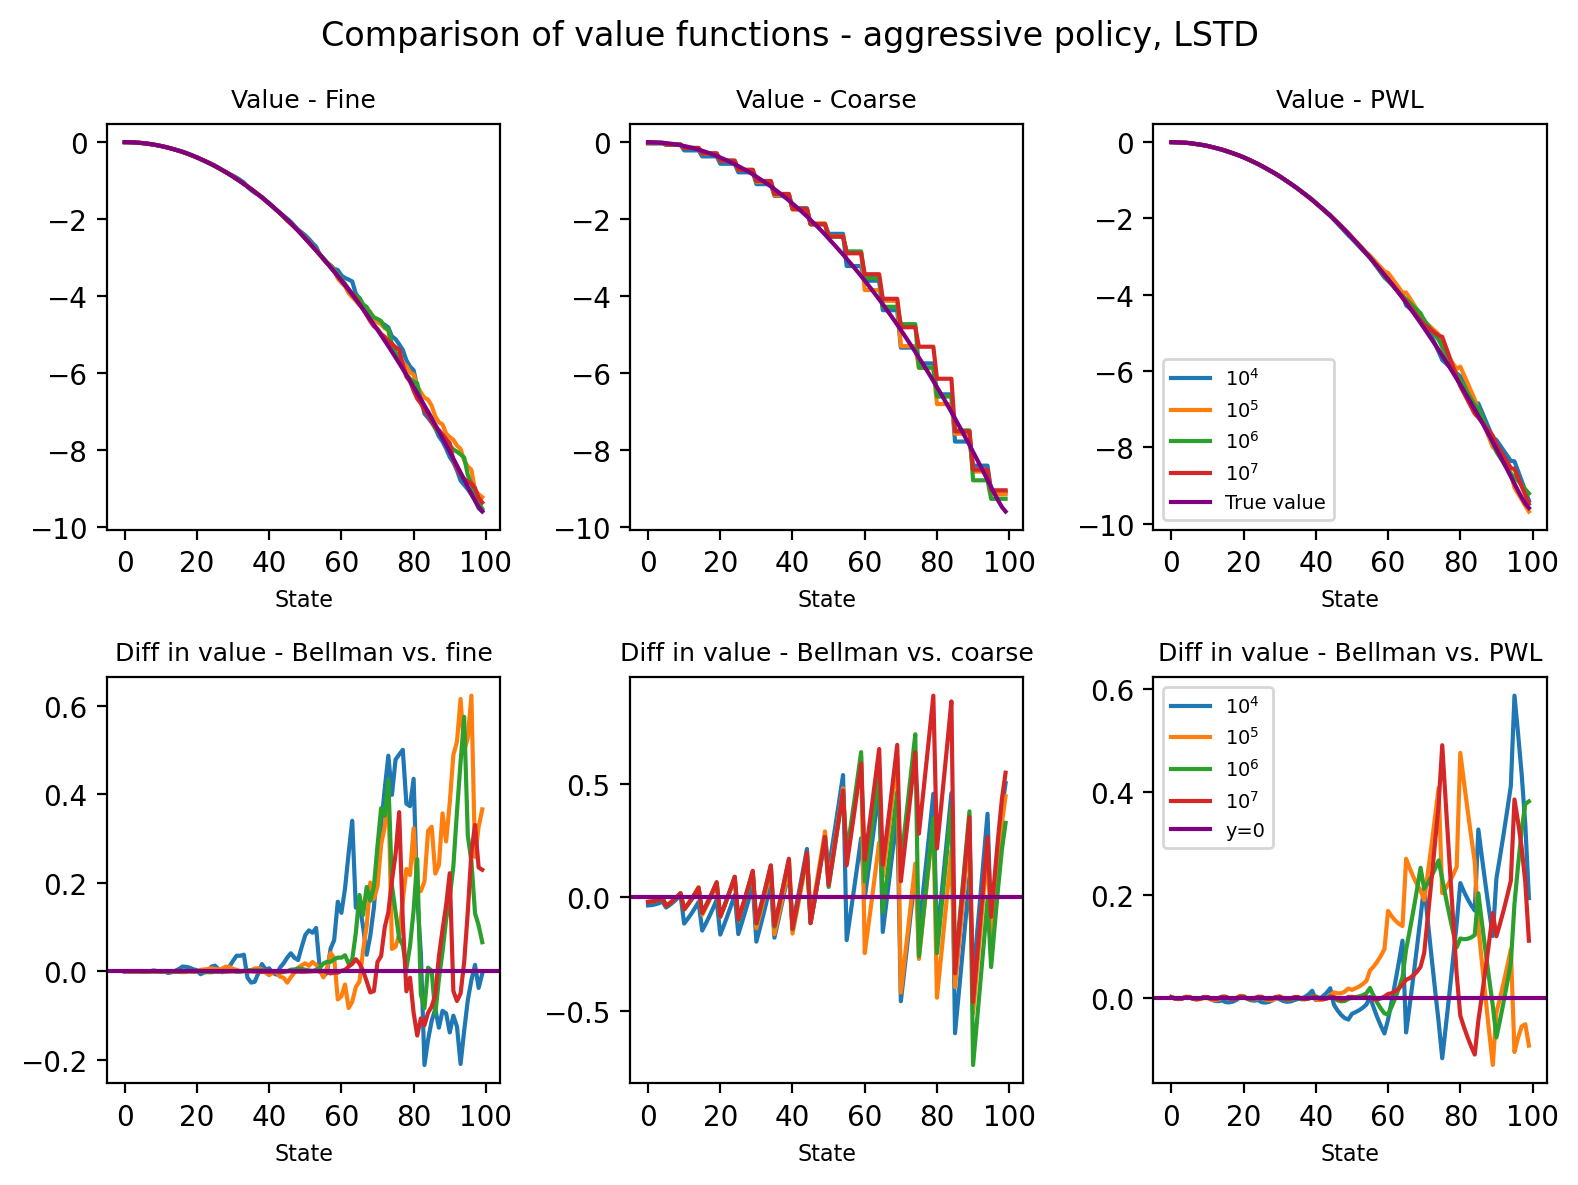

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6), dpi=200)
ax[0,0].plot(np.arange(100),results_df['LSTD_aggr_fine_4'], label = '$10^4$')
ax[0,0].plot(np.arange(100),results_df['LSTD_aggr_fine_5'], label = '$10^5$')
ax[0,0].plot(np.arange(100),results_df['LSTD_aggr_fine_6'], label = '$10^6$')
ax[0,0].plot(np.arange(100),results_df['LSTD_aggr_fine_7'], label = '$10^7$')
ax[0,0].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,0].set_title('Value - Fine', fontsize = 9)
ax[0,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_4'], label = '$10^4$')
ax[0,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_5'], label = '$10^5$')
ax[0,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_6'], label = '$10^6$')
ax[0,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_7'], label = '$10^7$')
ax[0,1].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,1].set_title('Value - Coarse', fontsize = 9)
ax[0,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_4'], label = '$10^4$')
ax[0,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_5'], label = '$10^5$')
ax[0,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_6'], label = '$10^6$')
ax[0,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_7'], label = '$10^7$')
ax[0,2].plot(np.arange(100),results_df['value_aggr'], label = 'True value', color="purple")
ax[0,2].set_title('Value - PWL', fontsize = 9)
ax[0,2].legend(loc='lower left', prop={'size': 7})
ax[1,0].plot(np.arange(100),results_df['LSTD_aggr_fine_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,0].plot(np.arange(100),results_df['LSTD_aggr_fine_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,0].plot(np.arange(100),results_df['LSTD_aggr_fine_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,0].plot(np.arange(100),results_df['LSTD_aggr_fine_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,0].axhline(y=0, label="y=0", color="purple")
ax[1,0].set_title('Diff in value - Bellman vs. fine', fontsize = 9)
ax[1,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,1].plot(np.arange(100),results_df['LSTD_aggr_coarse_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,1].axhline(y=0, label="y=0", color="purple")
ax[1,1].set_title('Diff in value - Bellman vs. coarse', fontsize = 9)
ax[1,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_4']-results_df['value_aggr'], label = '$10^4$')
ax[1,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_5']-results_df['value_aggr'], label = '$10^5$')
ax[1,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_6']-results_df['value_aggr'], label = '$10^6$')
ax[1,2].plot(np.arange(100),results_df['LSTD_aggr_pwl_7']-results_df['value_aggr'], label = '$10^7$')
ax[1,2].axhline(y=0, label="y=0", color="purple")
ax[1,2].set_title('Diff in value - Bellman vs. PWL', fontsize = 9)
ax[1,2].legend(loc='upper left', prop={'size': 7})
for axs in ax.flat:
    axs.set_xlabel('State', fontsize = 8)
    axs.set_xticks(np.arange(0, 101, step=20), fontsize=5)
    #axs.set_yticks(fontsize=5)
fig.suptitle('Comparison of value functions - aggressive policy, LSTD', fontsize=12)

plt.tight_layout()
plt.show()

### Answer
***Plot the resulting value functions and compare them to the results you have obtained in the first problem set.***

Plotting the value functions for TD(0) and LSTD for the lazy and aggressive policy under the various feature maps, we find that the TD(0) yields unstable estimates for both policies in high states (queue length > 50). The TD(0) estimates are systematically higher than the true values. This finding is independent of the feature maps used. In contrast, the LSTD is stable and converges to the optimal value function in steps determined by the features maps. Whilst the approximations for the fine and piece-wise linear feature maps are smooth, the coarse feature map exhibits a stepwise approximation. For LSTD, all approximations fluctuate closely around the true value function.

## Problem 2: Approximate policy iteration
Using the LSTD implementation, implement an approximate policy iteration method where the following steps are repeated in each iteration k:
+ **Policy evaluation**: Evaluate the current policy $\pi_k$ using LSTD and $10^5$ sample transitions, and let $\hat{V}_k$ denote the result.
+ **Policy improvement**: Define the $Q$-function estimate as
    $$\begin{aligned}
    \widehat{Q}_{k}(x, a)=& r(x, a) \\
    &+\gamma(1-p)\left(q(a) \widehat{V}_{k}(x-1)+(1-q(a)) \widehat{V}_{k}(x)\right) \\
    &+\gamma p\left(q(a) \widehat{V}_{k}(x)+(1-q(a)) \widehat{V}_{k}(x+1)\right)
    \end{aligned}
    $$ and set the new policy as the greedy policy with respect to $\widehat{Q}_{k}$:
    $$
    \pi_{k+1}(x)=\arg \max _{a} \widehat{Q}_{k}(x, a) .
    $$
Plot the value function $\widehat{V}_{k}$ after 10 and 100 iterations and compare it with the value functions obtained in the previous problem. Also plot the service rates assigned by final policy $\pi_{k}$ as a function of $x$ (i.e., $q\left(\pi_{k}(x)\right)$ for $\left.x=1,2, \ldots, N\right) $ and interpret the results, comparing them to the optimal value functions you have obtained in the first problem set. Did the final policy robustly improve on the initial policy?

### Approximate policy iteration

In [28]:
def approximate_policy_iteration(P,r,gamma,phi,V,max_iter):
    
    for k in range(max_iter):
        V_next = -np.inf*np.ones(X)
        Q_estimate = np.zeros((X,A))
        pi_greedy = np.zeros((X, A)) # initialize a policy
        
        # policy improvement
        for x in range(X):
            for a in range(A):
                # Edge case 1: no one in the queue
                if x == 0:
                    Q_estimate[x,a] = r[x,a] + gamma*(1-p)*V[x] + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])
                # Edge case 2: full queue
                elif x == (X-1):
                    Q_estimate[x,a] = r[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*V[x]
                # No edge cases
                else:
                    Q_estimate[x,a] = r[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])

                if Q_estimate[x,a] > V_next[x]:
                    V_next[x] = Q_estimate[x,a]
                    pi_greedy[x,:] = np.zeros(A)
                    pi_greedy[x,a] = 1
        
        # policy evaluation
        V = LSTD(P,reward,gamma,pi_greedy,phi,10**5,X-1)
    
    return V, pi_greedy


In [29]:
%%time

opt_values_aPI = []
opt_policies_aPI = []
feature_maps = [phi_fine, phi_coarse, phi_pwl]
iterations = [10, 100]

for phi in feature_maps:
    for i in iterations:
        opt_value_aPI, opt_policy_aPI = approximate_policy_iteration(P,reward,gamma,phi,np.zeros(X),i)
        opt_policies_aPI.append(opt_policy_aPI)
        opt_values_aPI.append(opt_value_aPI)

CPU times: user 2h 17min 1s, sys: 6min 21s, total: 2h 23min 23s
Wall time: 29min 34s


In [30]:
labels_aPI = []
feature_maps = ['fine', 'coarse', 'pwl']
iterations = ['10','100']

for phi in feature_maps:
    for i in iterations:
        label_aPI = 'aPI_' + phi + '_' + i
        labels_aPI.append(label_aPI)

In [31]:
results_PI = pd.DataFrame(np.transpose(opt_values_aPI), columns=labels_aPI)

### Compare to policy iteration from previous problem set

In [32]:
### policy iteration
# P: X by X by A transition matrix
# r: X-sized reward vector
# gamma: discount factor
# V: initial value-function estimate
# max_iter: number of iterations

def policy_iteration(P,r,gamma,V,max_iter):
    for k in range(max_iter):
        V_next = -np.inf*np.ones(X)
        Q_estimate = np.zeros((X,A))
        pi_greedy = np.zeros((X,A))
        for x in range(X):
            for a in range(A):
                Q_estimate[x,a] = r[x,a] + gamma*P[x,:,a].dot(V)
                if Q_estimate[x,a] > V_next[x]:
                    V_next[x] = Q_estimate[x,a]
                    pi_greedy[x,:] = np.zeros(A)
                    pi_greedy[x,a] = 1
        V = evaluate(P,pi_greedy,r,gamma)
    return V, pi_greedy

In [33]:
opt_value_PI, opt_policy_PI = policy_iteration(P,reward,gamma,np.zeros(X),10)

In [34]:
results_PI['optimal'] = opt_value_PI
results_PI

,aPI_fine_10,aPI_fine_100,aPI_coarse_10,aPI_coarse_100,aPI_pwl_10,aPI_pwl_100,optimal
0,-0.003194,-0.003091,-0.022117,-0.024956,-0.001533,-0.001518,-0.003187
1,-0.004599,-0.004515,-0.022117,-0.024956,-0.005574,-0.005530,-0.004632
2,-0.007613,-0.007613,-0.022117,-0.024956,-0.009615,-0.009542,-0.007783
3,-0.012311,-0.012551,-0.022117,-0.024956,-0.013656,-0.013554,-0.012778
4,-0.019003,-0.019480,-0.022117,-0.024956,-0.017697,-0.017567,-0.019691
...,...,...,...,...,...,...,...
95,-8.642705,-9.093819,-9.330571,-8.627801,-8.886887,-9.049195,-8.955624
96,-8.710036,-9.249494,-9.330571,-8.627801,-9.007871,-9.198518,-9.138346
97,-8.995380,-9.420096,-9.330571,-8.627801,-9.128854,-9.347841,-9.313731
98,-9.124221,-9.518155,-9.330571,-8.627801,-9.249838,-9.497163,-9.468326


### Calculate service rates assigned by final policy $\pi_k$ as a function of $x$

In [35]:
def find_service_rate(policy):
    service_rate = np.zeros(X)
    for x in range(X):
        if policy[x,0] == 1:
            service_rate[x] = 0.51
        else:
            service_rate[x] = 0.6

    return service_rate

In [36]:
service_rates = []

for policy in opt_policies_aPI:
    service_rate = find_service_rate(policy)
    service_rates.append(service_rate)

In [37]:
labels_sr = []
feature_maps = ['fine', 'coarse', 'pwl']
iterations = ['10','100']

for phi in feature_maps:
    for i in iterations:
        label_sr = 'sr_aPI_' + phi + '_' + i
        labels_sr.append(label_sr)

In [38]:
service_rates_PI = pd.DataFrame(np.transpose(service_rates), columns=labels_sr)
service_rates_PI['sr_optimal'] = find_service_rate(opt_policy_PI)
service_rates_PI

,sr_aPI_fine_10,sr_aPI_fine_100,sr_aPI_coarse_10,sr_aPI_coarse_100,sr_aPI_pwl_10,sr_aPI_pwl_100,sr_optimal
0,0.51,0.51,0.51,0.51,0.51,0.51,0.51
1,0.51,0.51,0.51,0.51,0.51,0.51,0.51
2,0.51,0.51,0.51,0.51,0.51,0.51,0.51
3,0.51,0.51,0.51,0.51,0.51,0.51,0.51
4,0.51,0.51,0.51,0.51,0.51,0.51,0.51
...,...,...,...,...,...,...,...
95,0.60,0.60,0.51,0.60,0.60,0.60,0.60
96,0.60,0.60,0.51,0.51,0.60,0.60,0.60
97,0.60,0.60,0.51,0.51,0.60,0.60,0.60
98,0.60,0.51,0.51,0.51,0.60,0.60,0.60


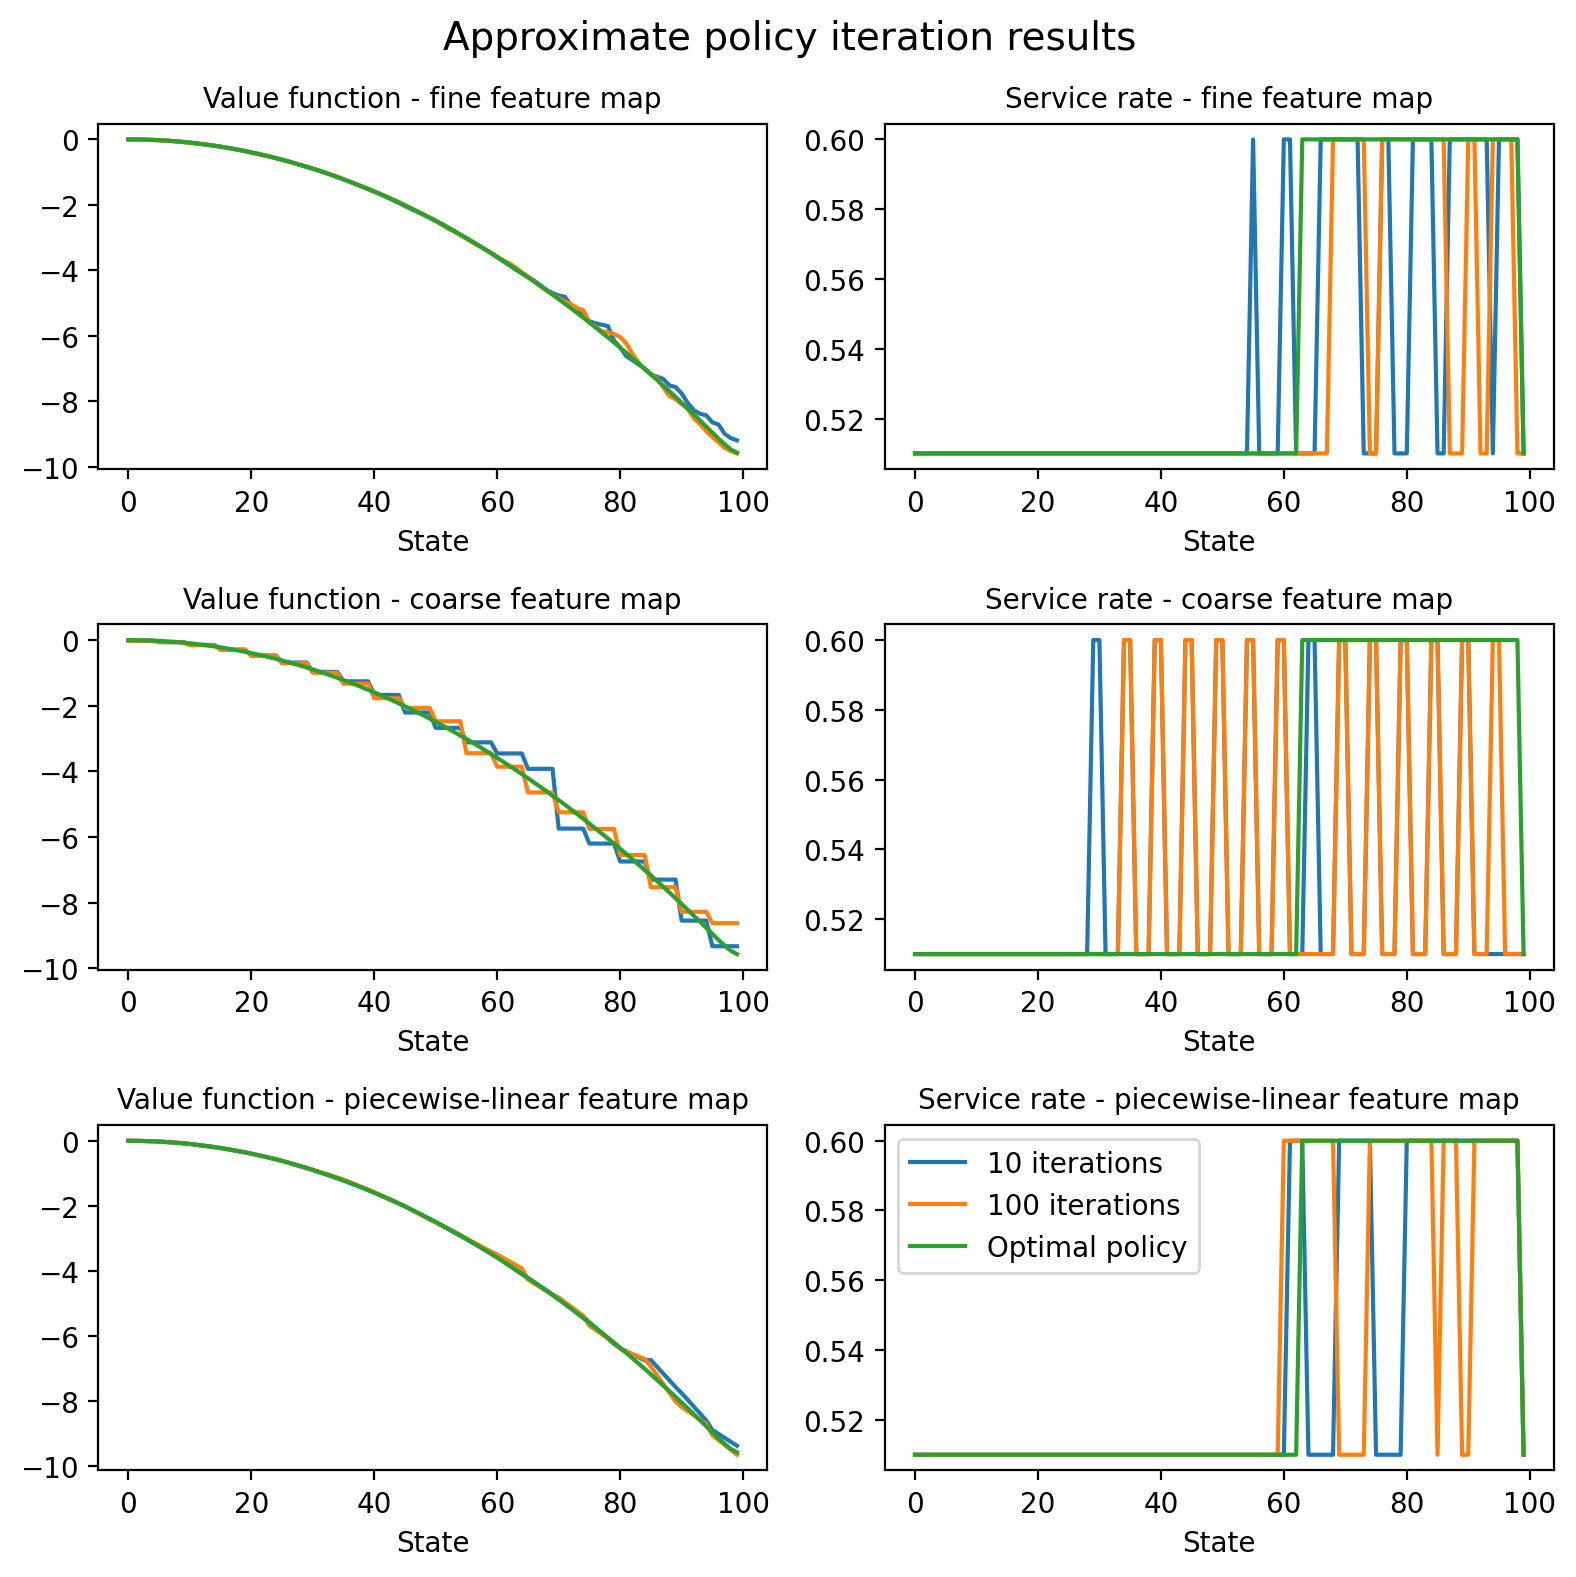

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(8, 8), dpi=200)
ax[0,0].plot(np.arange(100),results_PI['aPI_fine_10'], label = '10 iterations')
ax[0,0].plot(np.arange(100),results_PI['aPI_fine_100'], label = '100 iterations')
ax[0,0].plot(np.arange(100),results_PI['optimal'], label = 'Optimal policy')
ax[0,0].set_title('Value function - fine feature map', fontsize = 10)
ax[1,0].plot(np.arange(100),results_PI['aPI_coarse_10'], label = '10 iterations')
ax[1,0].plot(np.arange(100),results_PI['aPI_coarse_100'], label = '100 iterations')
ax[1,0].plot(np.arange(100),results_PI['optimal'], label = 'Optimal policy')
ax[1,0].set_title('Value function - coarse feature map', fontsize = 10)
ax[2,0].plot(np.arange(100),results_PI['aPI_pwl_10'], label = '10 iterations')
ax[2,0].plot(np.arange(100),results_PI['aPI_pwl_100'], label = '100 iterations')
ax[2,0].plot(np.arange(100),results_PI['optimal'], label = 'Optimal policy')
ax[2,0].set_title('Value function - piecewise-linear feature map', fontsize = 10)
ax[0,1].plot(np.arange(100),service_rates_PI['sr_aPI_fine_10'], label = '10 iterations')
ax[0,1].plot(np.arange(100),service_rates_PI['sr_aPI_fine_100'], label = '100 iterations')
ax[0,1].plot(np.arange(100),service_rates_PI['sr_optimal'], label = 'Optimal policy')
ax[0,1].set_title('Service rate - fine feature map', fontsize = 10)
ax[1,1].plot(np.arange(100),service_rates_PI['sr_aPI_coarse_10'], label = '10 iterations')
ax[1,1].plot(np.arange(100),service_rates_PI['sr_aPI_coarse_100'], label = '100 iterations')
ax[1,1].plot(np.arange(100),service_rates_PI['sr_optimal'], label = 'Optimal policy')
ax[1,1].set_title('Service rate - coarse feature map', fontsize = 10)
ax[2,1].plot(np.arange(100),service_rates_PI['sr_aPI_pwl_10'], label = '10 iterations')
ax[2,1].plot(np.arange(100),service_rates_PI['sr_aPI_pwl_100'], label = '100 iterations')
ax[2,1].plot(np.arange(100),service_rates_PI['sr_optimal'], label = 'Optimal policy')
ax[2,1].set_title('Service rate - piecewise-linear feature map', fontsize = 10)
for axs in ax.flat:
    axs.set(xlabel='State')
fig.suptitle('Approximate policy iteration results', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

### Answer
***Plot the value function $\widehat{V}_{k}$ after 10 and 100 iterations and compare it with the value functions obtained in the previous problem. Also plot the service rates assigned by final policy $\pi_{k}$ as a function of $x$ (i.e., $q\left(\pi_{k}(x)\right)$ for $\left.x=1,2, \ldots, N\right) $ and interpret the results, comparing them to the optimal value functions you have obtained in the first problem set. Did the final policy robustly improve on the initial policy?***

Plotting the value function $\widehat{V}_{k}$ after 10 and 100 iterations for the different features maps, we see that it behaves similar to the value function obtained from policy iteration in the previous problem set. The approximate values converge to the true values even if in a stepwise manner, as found for the coarse feature map. The coarse feature map is thus a worse proxy for the value function when compared to the fine and piecewise linear feature map. This is to be expected given that coarse feature map uses the fewest dimensions for estimating the value function. Both the fine and piecewise linear feature maps estimate the true value function equally well yielding smooth curves. Given that the piecewise linear feature map uses fewer dimensions than the fine feature map, we can say that this feature map is the most efficient at estimating the true value function.

In contrast to the estimated value functions, the service rates are unstable and fluctuate between the high and low service rate for the high states. This is found for all feature maps. Again, the fine and piecewise-linear feature maps perform better than the coarse feature map, but they do not converge to the service rates found for the optimal policy. It is thus unclear whether the final policy is a robust improvement to the initial policy.

# Correction: LSTD

In [ ]:
# generate a random queue for TD and LSTD algorithms
def run_queue(X, T, pi, x_0):
    """Random queue.
    
    Generaties a random queue for the LSTD algorithm
    
    Inputs:
    -------
    X : state space, int
    T : sample transitions, int
    pi : policy, np.array
    x_0 : initial state, int
    
    Returns:
    -------
    traj : sample trajectory
    """
    traj = np.zeros(T).astype(int)
    traj[0] = x_0
    
    for t in range(T-1):
        y = traj[t]
        a = pi[y, 1].astype(int)
        I = [1 if np.random.uniform() < p else 0][0]
        S = [1 if np.random.uniform() < q[a] else 0][0]
        traj[t+1] = min(X-1, max(1, y + I - S))
        
    return traj


def LSTD(reward,gamma,pi,phi,T,x_0,sigma=10**-10):
    """LSTD.
    
    Runs the LSTD algorithm.
    
    Inputs:
    ------
    reward : rewards, np.array
    gamma : discount factor, float
    pi : policy, np.array
    phi : feature map, np.array
    T : sample transitions, int
    x_0 : initial state, int
    
    Returns:
    -------
    value : value function, np.array
    end_state : end_state, int
    r_t_sum : sum of rewards
    """
    A = np.zeros((phi.shape[1], phi.shape[1]))
    A_1 = np.linalg.inv(A + (sigma*np.identity(phi.shape[1])))
    b = np.zeros(phi.shape[1])
    
    traj = run_queue(X, T, pi, x_0)
    end_state = traj[-1]
    r = reward[:,0]*pi[:,0] + reward[:,1]*pi[:,1]
    r_t_sum = 0

    for t in range(T-1):
        x = traj[t]
        x_new = traj[t+1]

        v = np.dot(A_1.T,phi[x,:] - gamma*phi[x_new,:])
        A_1 = A_1 - np.outer(np.dot(A_1, phi[x,:]), v.T)/(1 + np.dot(v, phi[x,:]))
        b += r[x]*phi[x,:]
        r_t_sum += r[x]
    
    theta = A_1.dot(b)
    value = phi.dot(theta)
    
    return value, end_state, r_t_sum